# Tutorial 1 - Basics of working with satellite data in Python

> History | Updated August 2023


## Objective

This tutorial will show the steps to grab data hosted on an ERDDAP server from Python, how to work with NetCDF files in Python and how to make some maps and time-series of sea surface temperature.


## The tutorial demonstrates the following techniques

- Locating a satellite product in ERDDAP, manually changing the constraints and copying the URL defining the data request
- Downloading the resulting netCDF file
- Opening and examining the netCDF file
- Making basic maps and time series plots


## Datasets used

**CoralTemp Sea Surface Temperature** product from the NOAA Coral Reef Watch program.
The NOAA Coral Reef Watch (CRW) daily global 5km Sea Surface Temperature (SST) product, also known as CoralTemp, shows the nighttime ocean temperature measured at the surface. The SST scale ranges from -2 to 35 °C.
The CoralTemp SST data product was developed from two, related reanalysis (reprocessed) SST products and a near real-time SST product. Spanning January 1, 1985 to the present, the CoralTemp SST is one of the best and most internally consistent daily global 5km SST products available.
More information about the product: https://coralreefwatch.noaa.gov/product/5km/index_5km_sst.php

We will use the monthly composite of this product and download it from the NOAA CoastWatch ERDDAP server:
https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.graph



## Import Python modules

In [ ]:
import urllib.request
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

## 1. Download data from ERDDAP using Python

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from Python using the URL structure. 

For example, the following page allows you to subset monthly sea surface temperature (SST) https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.html

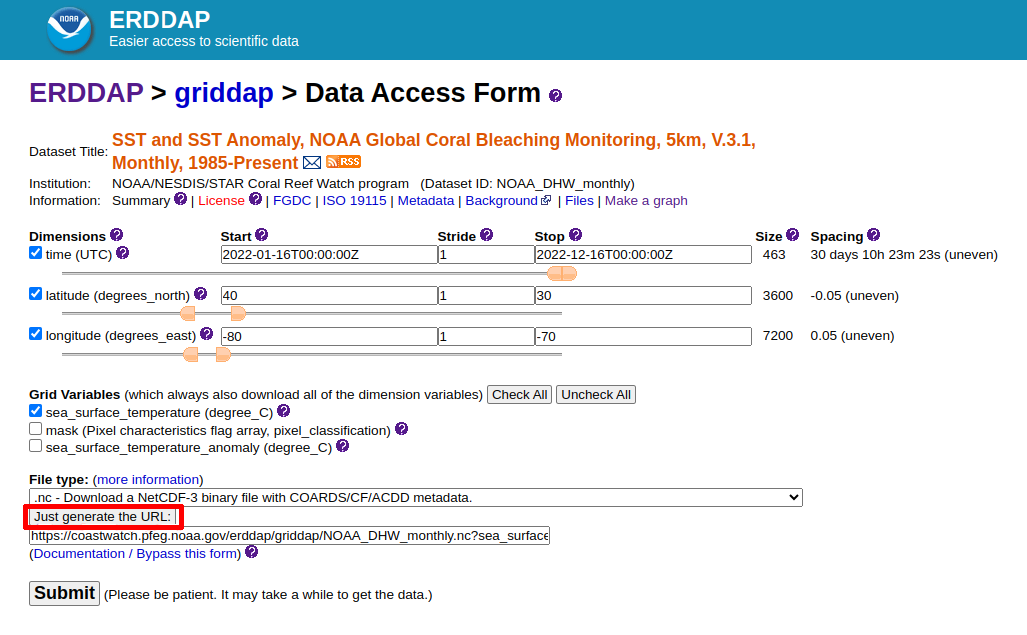

* Select your region and date range of interest, then select the '.nc' (NetCDF) file type and click on "Just Generate the URL".  

* In this specific example, the URL we generated is :  
https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.nc?sea_surface_temperature%5B(2022-01-16T00:00:00Z):1:(2022-12-16T00:00:00Z)%5D%5B(40):1:(30)%5D%5B(-80):1:(-70)%5D

### With Python, run the following to download the data using the generated URL .

In [57]:
# Below we have broken the url into parts and rejoin the them
# to allow you to better see the url in the notebook.
url = ''.join(['https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.nc?',
               'sea_surface_temperature',
               '%5B(2022-01-16T00:00:00Z):1:(2022-12-16T00:00:00Z)%5D',
               '%5B(40):1:(30)%5D%5B(-80):1:(-70)%5D'
               ])

urllib.request.urlretrieve(url, "sst.nc")

('sst.nc', <http.client.HTTPMessage at 0x1ac0e35b0>)

## 2. Loading netCDF4 data into Python

Now that we've downloaded the data locally, we can load it into Python and extract the variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

### Open the netCDF file as an xarray dataset object and examine the data structure.

In [12]:
ds = xr.open_dataset('sst.nc', decode_cf=True)
ds

<xarray.Dataset>
Dimensions:                  (time: 12, latitude: 202, longitude: 201)
Coordinates:
  * time                     (time) datetime64[ns] 2022-01-16 ... 2022-12-16
  * latitude                 (latitude) float32 40.03 39.97 ... 30.02 29.98
  * longitude                (longitude) float32 -80.02 -79.97 ... -70.07 -70.02
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 ...
Attributes: (12/65)
    acknowledgement:                  NOAA Coral Reef Watch program
    cdm_data_type:                    Grid
    comment:                          This is a product of NOAA Coral Reef Wa...
    contributor_name:                 NOAA Coral Reef Watch program
    contributor_role:                 Collecting source data and deriving pro...
    Conventions:                      CF-1.6, ACDD-1.3, COARDS
    ...                               ...
    time_coverage_duration:           P1M
    time_coverage_end:                2022-12-16T00:00:00Z
    time_coverage_resolution:         P1M
    time_coverage_start:              2022-01-16T00:00:00Z
    title:                            SST and SST Anomaly, NOAA Global Coral ...
    Westernmost_Easting:              -80.024994

### Examine which coordinates and variables are included in the dataset.

In [17]:
# List the coordinates
print('The coordinates variables:', list(ds.coords), '\n')

# List the data variables
print('The data variables:', list(ds.data_vars))

The coordinates variables: ['time', 'latitude', 'longitude'] 

The data variables: ['sea_surface_temperature']


### Examine the structure of sea_surface_temperature.

In [9]:
ds.sea_surface_temperature.shape

(12, 202, 201)

The dataset is a 3-D array with 12 time steps, each with 202 rows corresponding to latitudes and 201 columns corresponding to longitudes.

### List the dates for each time step.
The dataset has 12 time steps, one for each month between January 2022 and December 2022.  

In [19]:
ds.time

<xarray.DataArray 'time' (time: 12)>
array(['2022-01-16T00:00:00.000000000', '2022-02-16T00:00:00.000000000',
       '2022-03-16T00:00:00.000000000', '2022-04-16T00:00:00.000000000',
       '2022-05-16T00:00:00.000000000', '2022-06-16T00:00:00.000000000',
       '2022-07-16T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-09-16T00:00:00.000000000', '2022-10-16T00:00:00.000000000',
       '2022-11-16T00:00:00.000000000', '2022-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-16 2022-02-16 ... 2022-12-16
Attributes:
    _CoordinateAxisType:    Time
    actual_range:           [1.6422912e+09 1.6711488e+09]
    axis:                   T
    coverage_content_type:  coordinate
    ioos_category:          Time
    long_name:              reference time of the last day of the composite t...
    standard_name:          time
    time_origin:            01-JAN-1970 00:00:00

### Examine the latitude coordinate variable
Typically, the latitude coordinate variable will be in ascending order. However, in some datasets the order is reversed, i.e the order is descending.  

By examining the first and last values on our latitude array (below), we can see that the values are descending.  
* In practice what this means is that when you slice (subset) using latitude later in this tutorial, you will put the largest latitude value first.

In [39]:
print('First latitude value', ds.latitude[0].item())
print('Last latitude value', ds.latitude[-1].item())

First latitude value 40.025001525878906
Last latitude value 29.975004196166992


## 3. Working with the  data

### Creating a map for for January 2022 (our first time step)

#### Find the minimum and maximum SST values.

In [22]:
print('Minimum SST', np.nanmin(ds.sea_surface_temperature))
print('Maximum SST', np.nanmax(ds.sea_surface_temperature))

Minimum SST 2.34
Maximum SST 29.87


#### Use the minimum and maximum SST to set some color breaks.

In [41]:
# Sets color breaks from 2 to 30 with 0.05 steps
levs = np.arange(2, 30, 0.05)

#### Define a color palette.

In [42]:
jet = ["blue", "#007FFF", "cyan", "#7FFF7F",
       "yellow", "#FF7F00", "red", "#7F0000"]

#### Set color scale using the jet palette.

In [43]:
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

#### Plot the SST map
The code also shows how to annotate the map by: 
- Adding points to the map (e.g. station locations)
- Adding contour lines

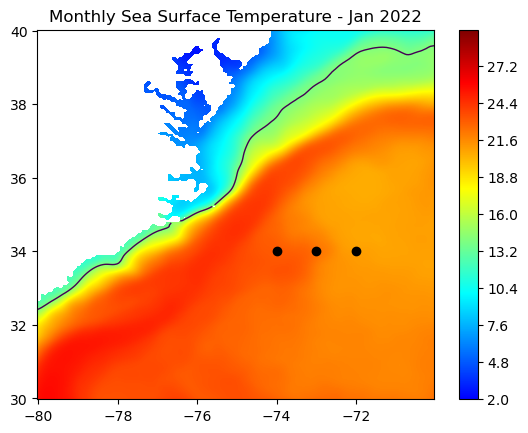

In [36]:
plt.contourf(ds.longitude, 
             ds.latitude, 
             ds.sea_surface_temperature[0, :, :], 
             levs,
             cmap=cm)

# Plot the colorbar
plt.colorbar()

# Annotation: Example of how to add points to the map
plt.scatter(range(-74, -71), np.repeat(34, 3), c='black')

# Annotation: Example of how to add a contour line
plt.contour(ds.longitude, 
            ds.latitude, 
            ds.sea_surface_temperature[0, :, :], 
            levels=[14],
            linewidths=1)

# Add a title
plt.title("Monthly Sea Surface Temperature - " 
          + ds.time[0].dt.strftime('%b %Y').item())
plt.show()

## Plotting a time series

### Subset the following box from the data: 
* 36<sup>o</sup> to 38<sup>o</sup>N latitude
* -77<sup>o</sup> to -75<sup>o</sup>E longitude  

We are going to generate a time series of mean SST within that box.

- First, subset the data:

**Remember!**  
For this product, latitudes are indexed in descending order (high to low). Therefore when you slice latitude, put the largest value first.

In [40]:
da = ds.sel(latitude=slice(38, 36), longitude=slice(-77, -75))

### Examine the structure of the subsetted data.
The subset is a 3-D array with 12 time steps, each with 40 rows corresponding to latitudes and 40 columns corresponding to longitudes.

In [53]:
da.sea_surface_temperature.shape

(12, 40, 40)

### Plot the subsetted data

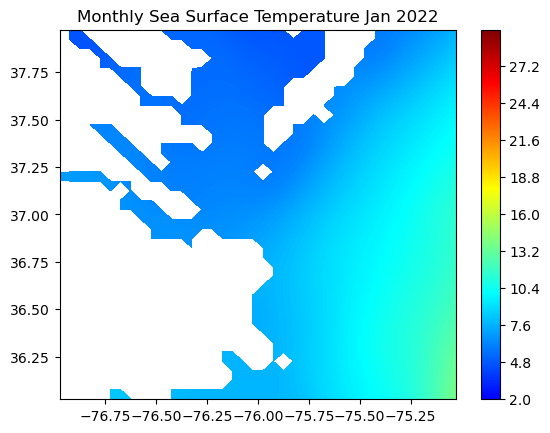

In [46]:
plt.contourf(da.longitude, 
             da.latitude, 
             da.sea_surface_temperature[0, :, :], 
             levs,
             cmap=cm)
plt.colorbar()
plt.title("Monthly Sea Surface Temperature " 
          + ds.time[0].dt.strftime('%b %Y').item())
plt.show()  

## Compute the monthly mean for each month

In [54]:
res = np.mean(da.sea_surface_temperature, axis=(1, 2))

### Plot the time-series

Text(0, 0.5, 'SST (ºC)')

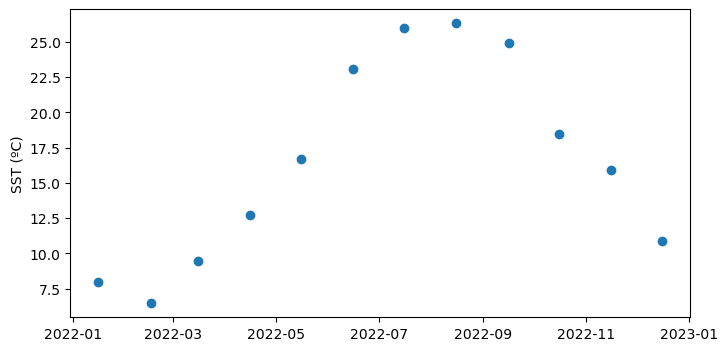

In [55]:
plt.figure(figsize=(8, 4))
plt.scatter(ds.time, res)
plt.ylabel('SST (ºC)')

## Creating a map of average SST over a year
### Compute the yearly mean for the region

In [56]:
mean_sst = np.mean(ds.sea_surface_temperature, axis=0)

### Plot the map of the 2022 average SST in the region

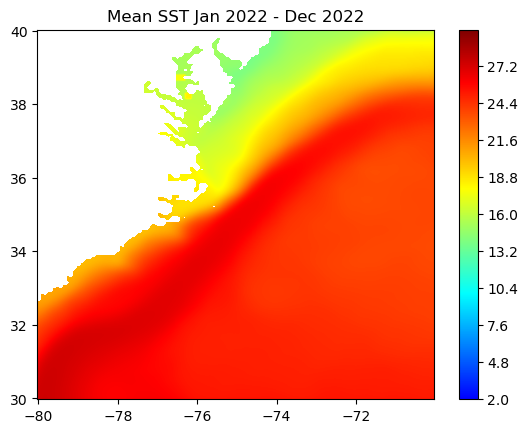

In [52]:
plt.contourf(ds.longitude, ds.latitude, mean_sst, levs, cmap=cm)
plt.colorbar()
plt.title("Mean SST " 
          + ds.time[0].dt.strftime('%b %Y').item() 
          + ' - '
          + ds.time[11].dt.strftime('%b %Y').item())

plt.show()